## Setup and Import Libraries

In [1]:
import os
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_tavily import TavilySearch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain import hub
from langgraph.graph import END, StateGraph, START
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

## Create Retriever

In [5]:
def create_retriever(urls, chunk_size=500, chunk_overlap=0):
    # Load Documents
    documents = [WebBaseLoader(url).load() for url in urls]
    documents_list = [item for document in documents for item in document]

    # Perform Splitting
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(documents=documents_list)

    # Add to Vector Store
    vector_store = FAISS.from_documents(
        documents=chunks,
        embedding=embeddings
    )

    return vector_store.as_retriever()

In [6]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

retriever = create_retriever(urls=urls, chunk_size=500, chunk_overlap=0)
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000016CFD20A8A0>, search_kwargs={})

## Create Retriver Grader

In [8]:
class GradeDocuments(BaseModel):
    """ 
    Binary Score for Relevance Check on Retrieved Documents
    """
    binary_score:str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(schema=GradeDocuments)

In [9]:
system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [10]:
retrieval_grader = grade_prompt | structured_llm_grader

In [11]:
question = "agent memory"

result = retriever.invoke(input=question)[1].page_content

print(retrieval_grader.invoke({"question": question, "document": result}))

binary_score='yes'


## Generate Answer

In [12]:
prompt = hub.pull("rlm/rag-prompt")

def format_documents(documents):
    return "\n\n".join(document.page_content for document in documents)

In [13]:
rag_chain = prompt | llm | StrOutputParser()

In [14]:
generation = rag_chain.invoke({"context": result, "question": question})
print(generation)

Agent memory is a long-term memory module that records agents' experiences in natural language. Each element in the memory stream is an observation or event provided by the agent. The retrieval model uses this context to inform the agent's behavior based on relevance, recency, and importance.


## Rewrite Query

In [15]:
rewrite_system_prompt = """
    You a question re-writer that converts an input question to a better version that is optimized
    for web search. Look at the input and try to reason about the underlying semantic intent / meaning.
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewrite_system_prompt),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [16]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

question_rewriter.invoke({"question": question})

'What is the role of memory in artificial intelligence agents?'

## Web Search

In [17]:
web_search_tool = TavilySearch(max_results=3)

## Graph State

In [18]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

## Nodes

In [19]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(input=question)
    return {"documents": documents, "question": question}

In [20]:
def generate_answer(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke(input={"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [21]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for document in documents:
        score = retrieval_grader.invoke(
            input={"question": question, "document": document.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(document)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [22]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    improved_question = question_rewriter.invoke(input={"question": question})
    return {"documents": documents, "question": improved_question}

In [23]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    results = web_search_tool.invoke(input={"query": question})
    web_results = "\n".join([result["content"] for result in results['results']])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

## Edges

In [24]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Workflow

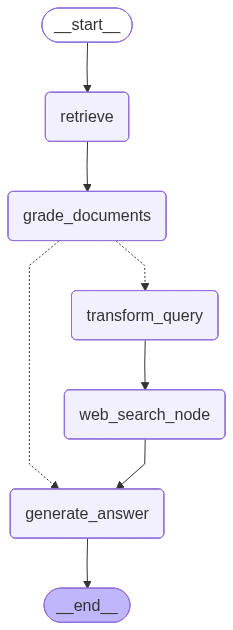

In [25]:
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node(node="retrieve", action=retrieve)
workflow.add_node(node="grade_documents", action=grade_documents)
workflow.add_node(node="generate_answer", action=generate_answer)
workflow.add_node(node="transform_query", action=transform_query)
workflow.add_node(node="web_search_node", action=web_search)

# Add Edges
workflow.add_edge(start_key=START, end_key="retrieve")
workflow.add_edge(start_key="retrieve", end_key="grade_documents")
workflow.add_conditional_edges(
    source="grade_documents",
    path=decide_to_generate,
    path_map={
        "transform_query": "transform_query",
        "generate_answer": "generate_answer",
    },
)
workflow.add_edge(start_key="transform_query", end_key="web_search_node")
workflow.add_edge(start_key="web_search_node", end_key="generate_answer")
workflow.add_edge(start_key="generate_answer", end_key=END)

# Compile
graph = workflow.compile()

graph

In [26]:
graph.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': 'What different types of memory do agents possess?',
 'generation': 'Agents possess short-term memory, which is utilized for in-context learning, and long-term memory, allowing them to retain and recall information over extended periods. These memory types enable agents to learn from past experiences, refine actions, and improve the quality of their results.',
 'web_search': 'Yes',
 'documents': [Document(id='6c6d5009-f20f-4937-9f73-072a011851f1', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered